# Lost Person Search Area Prediction Based on Regression and Transfer Learning Models
>[1] L. Šerić, T. Pinjušić, K. Topić, and T. Blažević, ‘Lost Person Search Area Prediction Based on Regression and Transfer Learning Models’, IJGI, vol. 10, no. 2, p. 80, Feb. 2021, doi: 10.3390/ijgi10020080.

>[2] Lidar Composite Digital Terrain Model Scotland (Phase2) 1m resolution [ASC geospatial data], Scale 1:4000, Tiles: nr82ne,nr83se,nr92nw,nr92sw,nr93sw,nr91ne,nr92ne,nr92se,nr93se,ns02ne,ns02nw,ns02se,ns02sw,ns03se,ns03sw, Updated: 1 July 2014, Non-Commercial Government Licence, Using: EDINA LIDAR Digimap Service, <https://digimap.edina.ac.uk>, Downloaded: 2022-01-28 13:08:03.643

>[3] Land Cover Map 2020 [GeoPackage geospatial data], Scale 1:250000, Tiles: GB, Updated: 10 September 2021, CEH, Using: EDINA Environment Digimap Service, <https://digimap.edina.ac.uk>, Downloaded: 2022-01-28 13:18:37.865

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio.plot as rioplot
import rasterio.windows as riow

import geopandas as gpd

from LR_Sim import LR_Sim
from jsim.Util import RasterMap

/home/jhewers/Documents/projects/jsim/examples/PDM_Generation/LinearRegression_w_TL/LR_Sim.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dem = RasterMap('5m_arran_b_merged.tif')
slope = RasterMap('5m_arran_b_merged_slope.tif')
lcid = gpd.read_file('arran_lcm_2020.gpkg')
lcid['_mode'] = lcid['_mode'].astype(np.uint8)

lcid_labels = {1:"Broadleaved woodland",
    2:"Coniferous Woodland",
    3:"Arable and Horticulture",
    4:"Improved Grassland",
    5:"Neutral Grassland",
    6:"Calcareous Grassland",
    7:"Acid grassland",
    8:"Fen, Marsh and Swamp",
    9:"Heather",
    10:"Heather grassland",
    11:"Bog",
    12:"Inland Rock",
    13:"Saltwater",
    14:"Freshwater",
    15:"Supra-littoral Rock",
    16:"Supra-littoral Sediment",
    17:"Littoral Rock",
    18:"Littoral sediment",
    19:"Saltmarsh",
    20:"Urban",
    21:"Suburban"
}
k = np.array(list(lcid_labels.keys()))
v = np.array(list(lcid_labels.values()))
mapping_ar = np.zeros(k.max()+1, dtype=v.dtype)
mapping_ar[k] = v
lcid['label'] = mapping_ar[lcid['_mode']]

lcid.head()

id  _conf                 _hist  _mode   _n _purity _stdev _agg  \
0  1001773   58.1      1:4,4:165,10:101      4  270   61.11  12.53    4   
1  1236986  73.27             1:29,4:65      4   94   69.15  22.54    4   
2       47  97.28                 4:159      4  159     100   5.34    4   
3   892738  88.94                 4:220      4  220     100  11.64    4   
4  5051091   74.7  1:42,3:4,4:12,10:613     10  671   91.36  14.62    6   

       gid                                           geometry  \
0  6421163  MULTIPOLYGON (((201043.83839 645863.24969, 201...   
1  5253892  MULTIPOLYGON (((201274.79811 645933.72928, 201...   
2   683721  MULTIPOLYGON (((201167.06943 645982.06618, 201...   
3  3610831  MULTIPOLYGON (((201001.59000 646137.80000, 201...   
4  5863451  MULTIPOLYGON (((201398.56846 645866.19113, 201...   

                label  
0  Improved Grassland  
1  Improved Grassland  
2  Improved Grassland  
3  Improved Grassland  
4   Heather grassland

In [1], Šerić et al. translate the Corine Land Cover codes to their on identification code. This would have given them a continuous id to use within their linear regression. Otherwise, similar values such as "Agro-Forestry Areas" (244) and "Broad-Leaved Forest" (311) would have a gap of 67 rather than 1. We must do the same for the local dataset being used, the Isle of Arran in this case.

For this dataset, we have a selection of 16/21 of the UKCEH Land Cover Classes:

| Local DB ID | UKCEH Land Cover Class  | UKCEH Aggregate Class      |
|-------------|-------------------------|----------------------------|
| 0           | Improved Grassland      | Improved Glassland         |
| 1           | Heather grassland       | Semi-natural Grassland     |
| 2           | Broadleaved woodland    | Broadleaved woodland       |
| 3           | Supra-littoral Rock     | Coastal                    |
| 4           | Coniferous Woodland     | Coniferous woodland        |
| 5           | Littoral sediment       | Coastal                    |
| 6           | Heather                 | Mountain, heath and bog    |
| 7           | Arable and Horticulture | Arable                     |
| 8           | Suburban                | Built-up areas and gardens |
| 9           | Urban                   | Built-up areas and gardens |
| 10          | Saltmarsh               | Coastal                    |
| 11          | Saltwater               | Saltwater                  |
| 12          | Bog                     | Mountain, heath and bog    |
| 13          | Acid grassland          | Semi-natural grassland     |
| 14          | Freshwater              | Freshwater                 |
| 15          | Supra-littoral Sediment | Coastal                    |
| 16          | Inland Rock             | Mountain, heath and bog    |

We then must map it to the very sparse LCid table from [1] to get:


| Original Label              | Equivalent  UKCEH Land Cover Class(es)                                                                          | LC id |
|-----------------------------|-----------------------------------------------------------------------------------------------------------------|-------|
| Agro-forestry areas         | Arable                                                                                                          | 22    |
| Broad-leaved forest         | Broadleaf woodland                                                                                              | 23    |
| Coniferous forest           | Coniferous woodland                                                                                             | 24    |
| Mixed forest                | Coniferous woodland                                                                                             | 25    |
| Natural grasslands          | Neutral grassland,  Calcareous grassland, Acid grassland                                                        | 26    |
| Moors and heathland         | Heather grassland, Bog, Inland rock, Supra-littoral rock, Supra-litorral sediment, Littoral sediment, Saltmarsh | 27    |
| Sclerophyllous vegetation   | Heather                                                                                                         | 28    |
| Transitional woodland-shrub | Improve grassland, Urban, Suburban,                                                                             | 29    |

In [3]:
labels_conversion = {
    1:23,
    2:24,
    3:22,
    4:29,
    5:26,
    6:26,
    7:26,
    8:27,
    9:28,
    10:27,
    11:27,
    12:27,
    13:1000,  # saltwater
    14:1000,  # freshwater
    15:27,
    16:27,
    17:27,
    18:27,
    19:27,
    20:29,
    21:29
}
k = np.array(list(labels_conversion.keys()))
v = np.array(list(labels_conversion.values()))
mapping_ar = np.zeros(k.max()+1, dtype=v.dtype)
mapping_ar[k] = v
lcid['lcid'] = mapping_ar[lcid['_mode']]

lcid.head()

id  _conf                 _hist  _mode   _n _purity _stdev _agg  \
0  1001773   58.1      1:4,4:165,10:101      4  270   61.11  12.53    4   
1  1236986  73.27             1:29,4:65      4   94   69.15  22.54    4   
2       47  97.28                 4:159      4  159     100   5.34    4   
3   892738  88.94                 4:220      4  220     100  11.64    4   
4  5051091   74.7  1:42,3:4,4:12,10:613     10  671   91.36  14.62    6   

       gid                                           geometry  \
0  6421163  MULTIPOLYGON (((201043.83839 645863.24969, 201...   
1  5253892  MULTIPOLYGON (((201274.79811 645933.72928, 201...   
2   683721  MULTIPOLYGON (((201167.06943 645982.06618, 201...   
3  3610831  MULTIPOLYGON (((201001.59000 646137.80000, 201...   
4  5863451  MULTIPOLYGON (((201398.56846 645866.19113, 201...   

                label lcid  
0  Improved Grassland   29  
1  Improved Grassland   29  
2  Improved Grassland   29  
3  Improved Grassland   29  
4   Heather grassland   27

<AxesSubplot:>

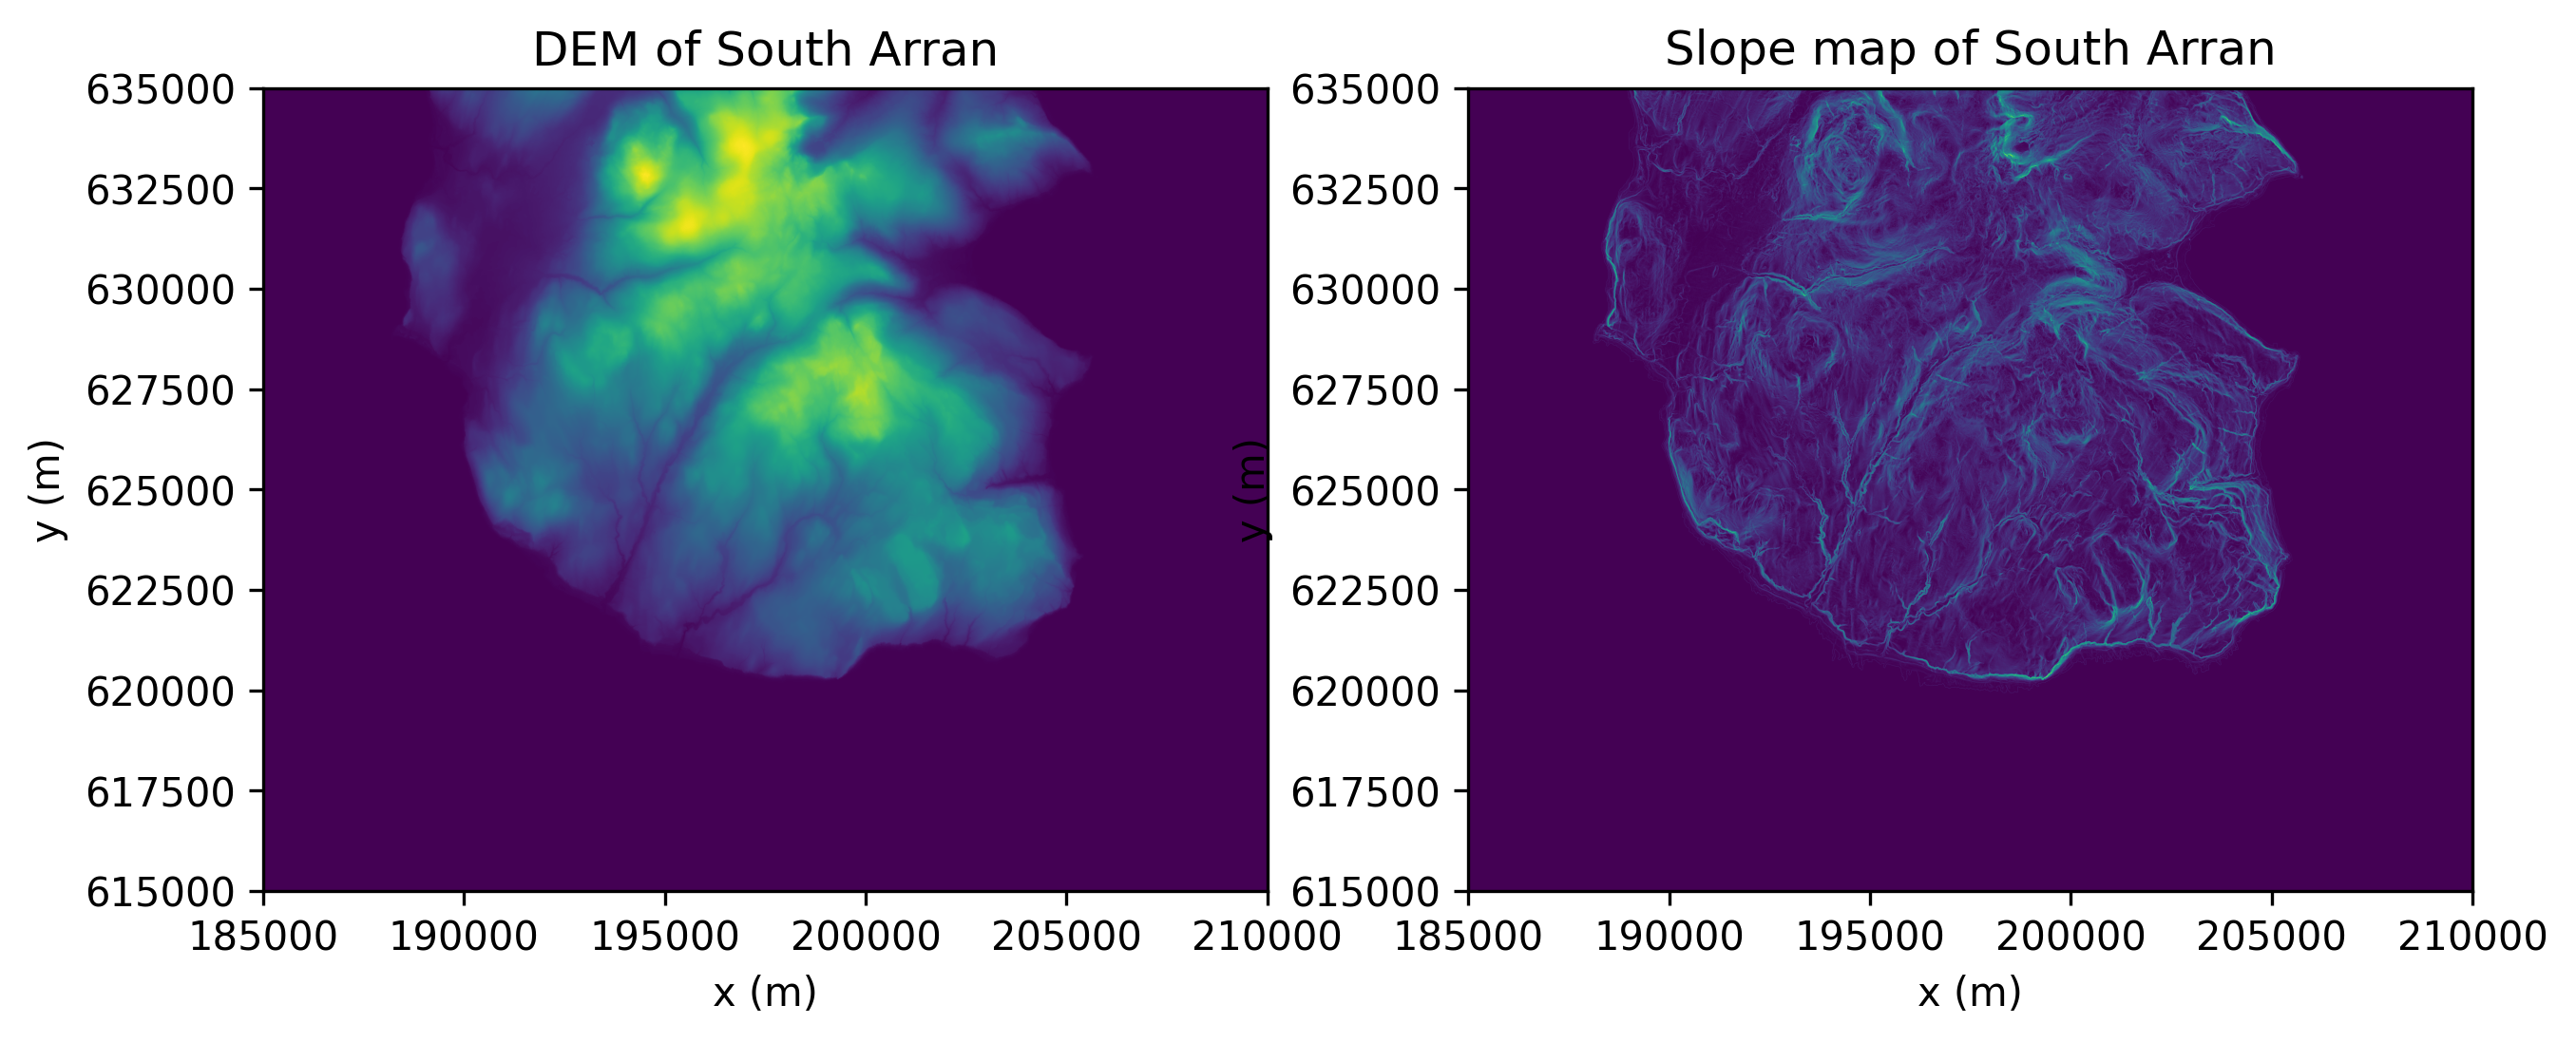

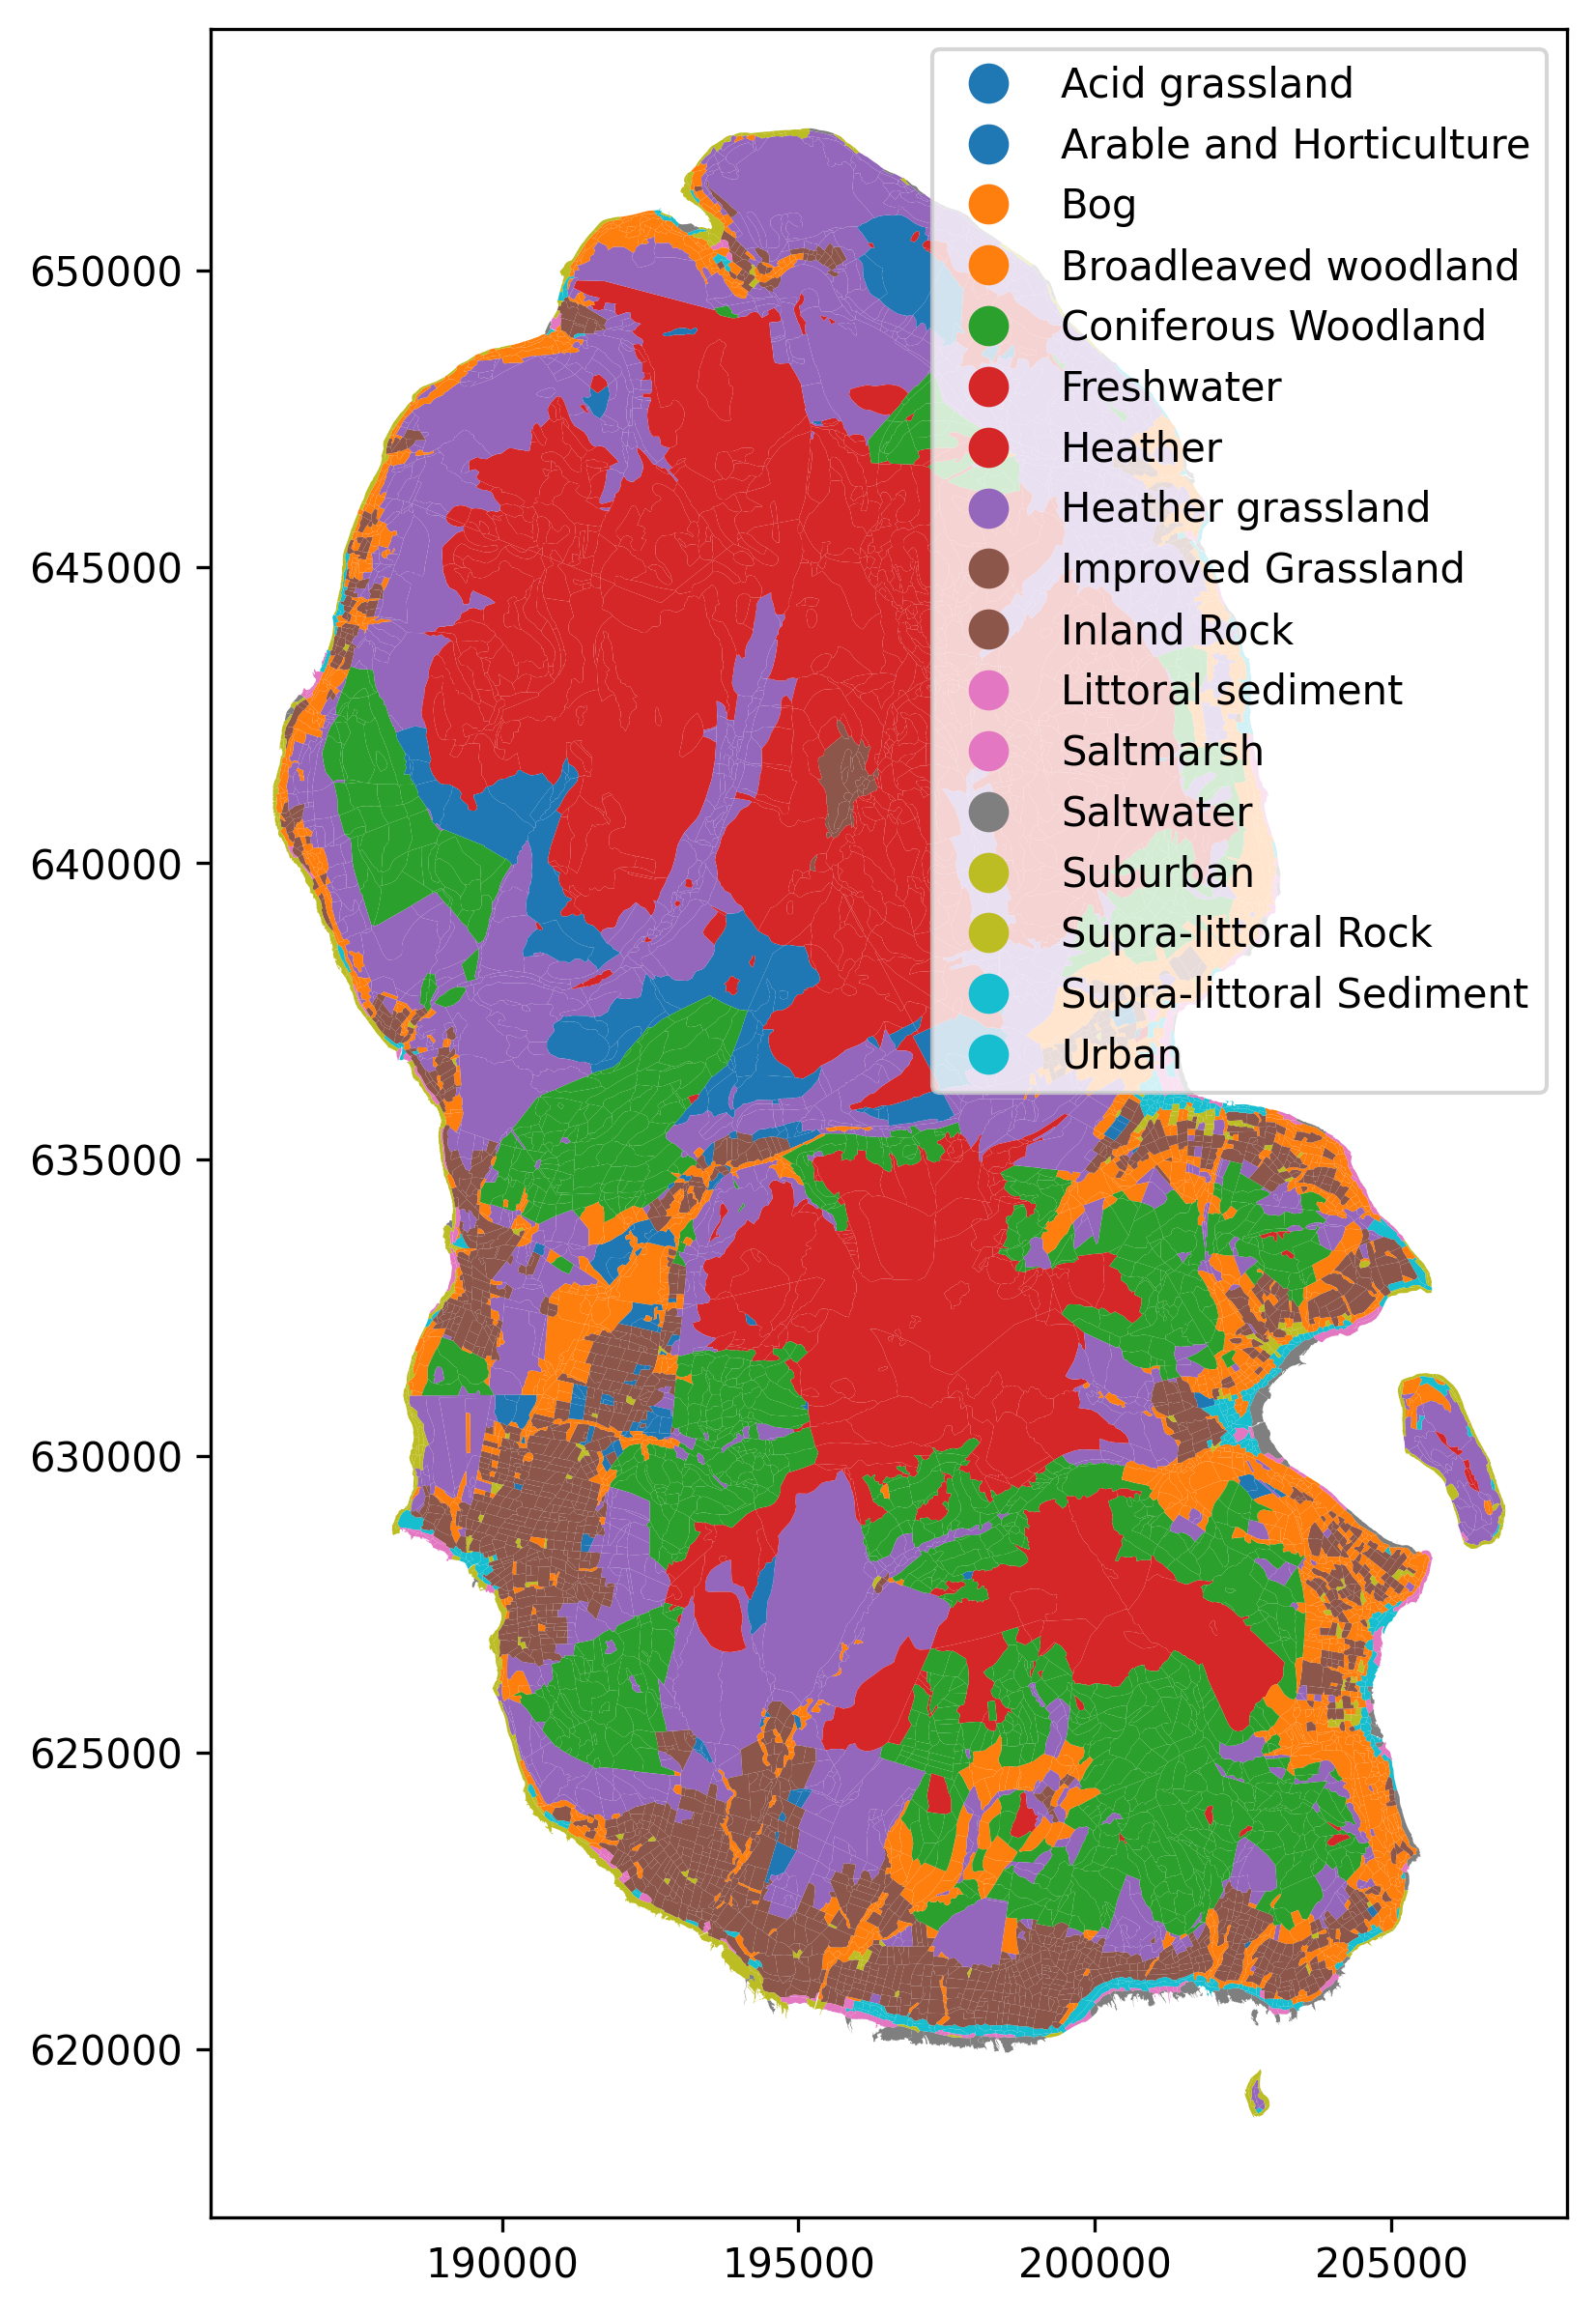

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10), dpi=300)

ax1.set_title("DEM of South Arran")
ax2.set_title("Slope map of South Arran")
for ax in [ax1, ax2]:
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

rioplot.show(dem._map, ax=ax1)
rioplot.show(slope._map, ax=ax2)

fig, ax = plt.subplots(figsize=(10,10), dpi=300)
lcid.plot(aspect=1, ax=ax, column='label', legend=True)

In [5]:
sim = LR_Sim("5m_arran_b_merged.tif","5m_arran_b_merged_slope.tif","arran_lcm_2020.gpkg")

sim.steps(400, 1200)

2022-02-10 14:39:14.598 | DEBUG    | LR_Env:__init__:59 - Instantiating LR_Env with start=Coord(x=2500, y=2000) and scale=5
2022-02-10 14:39:14.655 | DEBUG    | LR_Env:__init__:61 - self.dem=RasterMap(width=5000, height=4000) initiated
2022-02-10 14:39:14.728 | DEBUG    | LR_Env:__init__:63 - self.slope=RasterMap(width=5000, height=4000) initiated
2022-02-10 14:39:15.397 | DEBUG    | LR_Env:_CONVERT_UKCEH_TO_LCID:14 - Converting UKCEH IDs to LCIDs for vmap=VectorMap(8776854154144)
2022-02-10 14:39:15.400 | DEBUG    | LR_Env:_CONVERT_UKCEH_TO_LCID:44 - Converted UKCEH IDs to LCIDs for vmap=VectorMap(8776854154144)
2022-02-10 14:39:15.400 | DEBUG    | LR_Env:__init__:65 - self.lcid=VectorMap(8776854154144) initiated
2022-02-10 14:39:15.401 | DEBUG    | LR_Env:reset:75 - Resetting with start=Coord(x=2500, y=2000)


  0%|          | 0/400 [00:00<?, ?it/s]

2022-02-10 14:44:16.072 | DEBUG    | LR_Sim:steps:107 - Max. distance above threshold (1200m). Stopping simulation


In [16]:
z = sim.times

z[np.isinf(z)] = np.nan
tmp_z = np.copy(z)
tmp_z_sum_y = np.nansum(tmp_z, axis=1)
tmp_z_sum_x = np.nansum(tmp_z, axis=0)
tmp_z_sum_x[tmp_z_sum_x == 0] = np.nan
tmp_z_sum_y[tmp_z_sum_y == 0] = np.nan

min_x = np.where(tmp_z_sum_x==tmp_z_sum_x[np.isfinite(tmp_z_sum_x)][0])[0]
max_x = np.where(tmp_z_sum_x==tmp_z_sum_x[np.isfinite(tmp_z_sum_x)][-1])[0]
min_y = np.where(tmp_z_sum_y==tmp_z_sum_y[np.isfinite(tmp_z_sum_y)][0])[0]
max_y = np.where(tmp_z_sum_y==tmp_z_sum_y[np.isfinite(tmp_z_sum_y)][-1])[0]

# rio reads from top down, so lower y is higher transformed y
#        \/
min_xt, max_yt = dem.xy(min_y, min_x)
max_xt, min_yt = dem.xy(max_y, max_x)
min_xt, max_xt, min_yt, max_yt = [int(f[0]) for f in (min_xt, max_xt, min_yt, max_yt)]

def plot(a, b, a_label, b_label):
    fig, ax = plt.subplots(figsize=(8,8), dpi=300)
    b_plot = ax.contour(
        b._map.read(1, window=riow.Window(min_x, min_y, max_x-min_x, max_y-min_y)),
        levels=20,
        alpha=0.6,
        linewidths=0.8,
        cmap='gray',
        extent=[min_x, max_x, min_y, max_y])
    a_plot = ax.contourf(a)
    ax.scatter(sim.start.x, sim.start.y)
    fig.colorbar(b_plot, label=b_label)
    fig.colorbar(a_plot, orientation='horizontal', label=a_label)
    ax.set_aspect('equal')
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    plt.show()

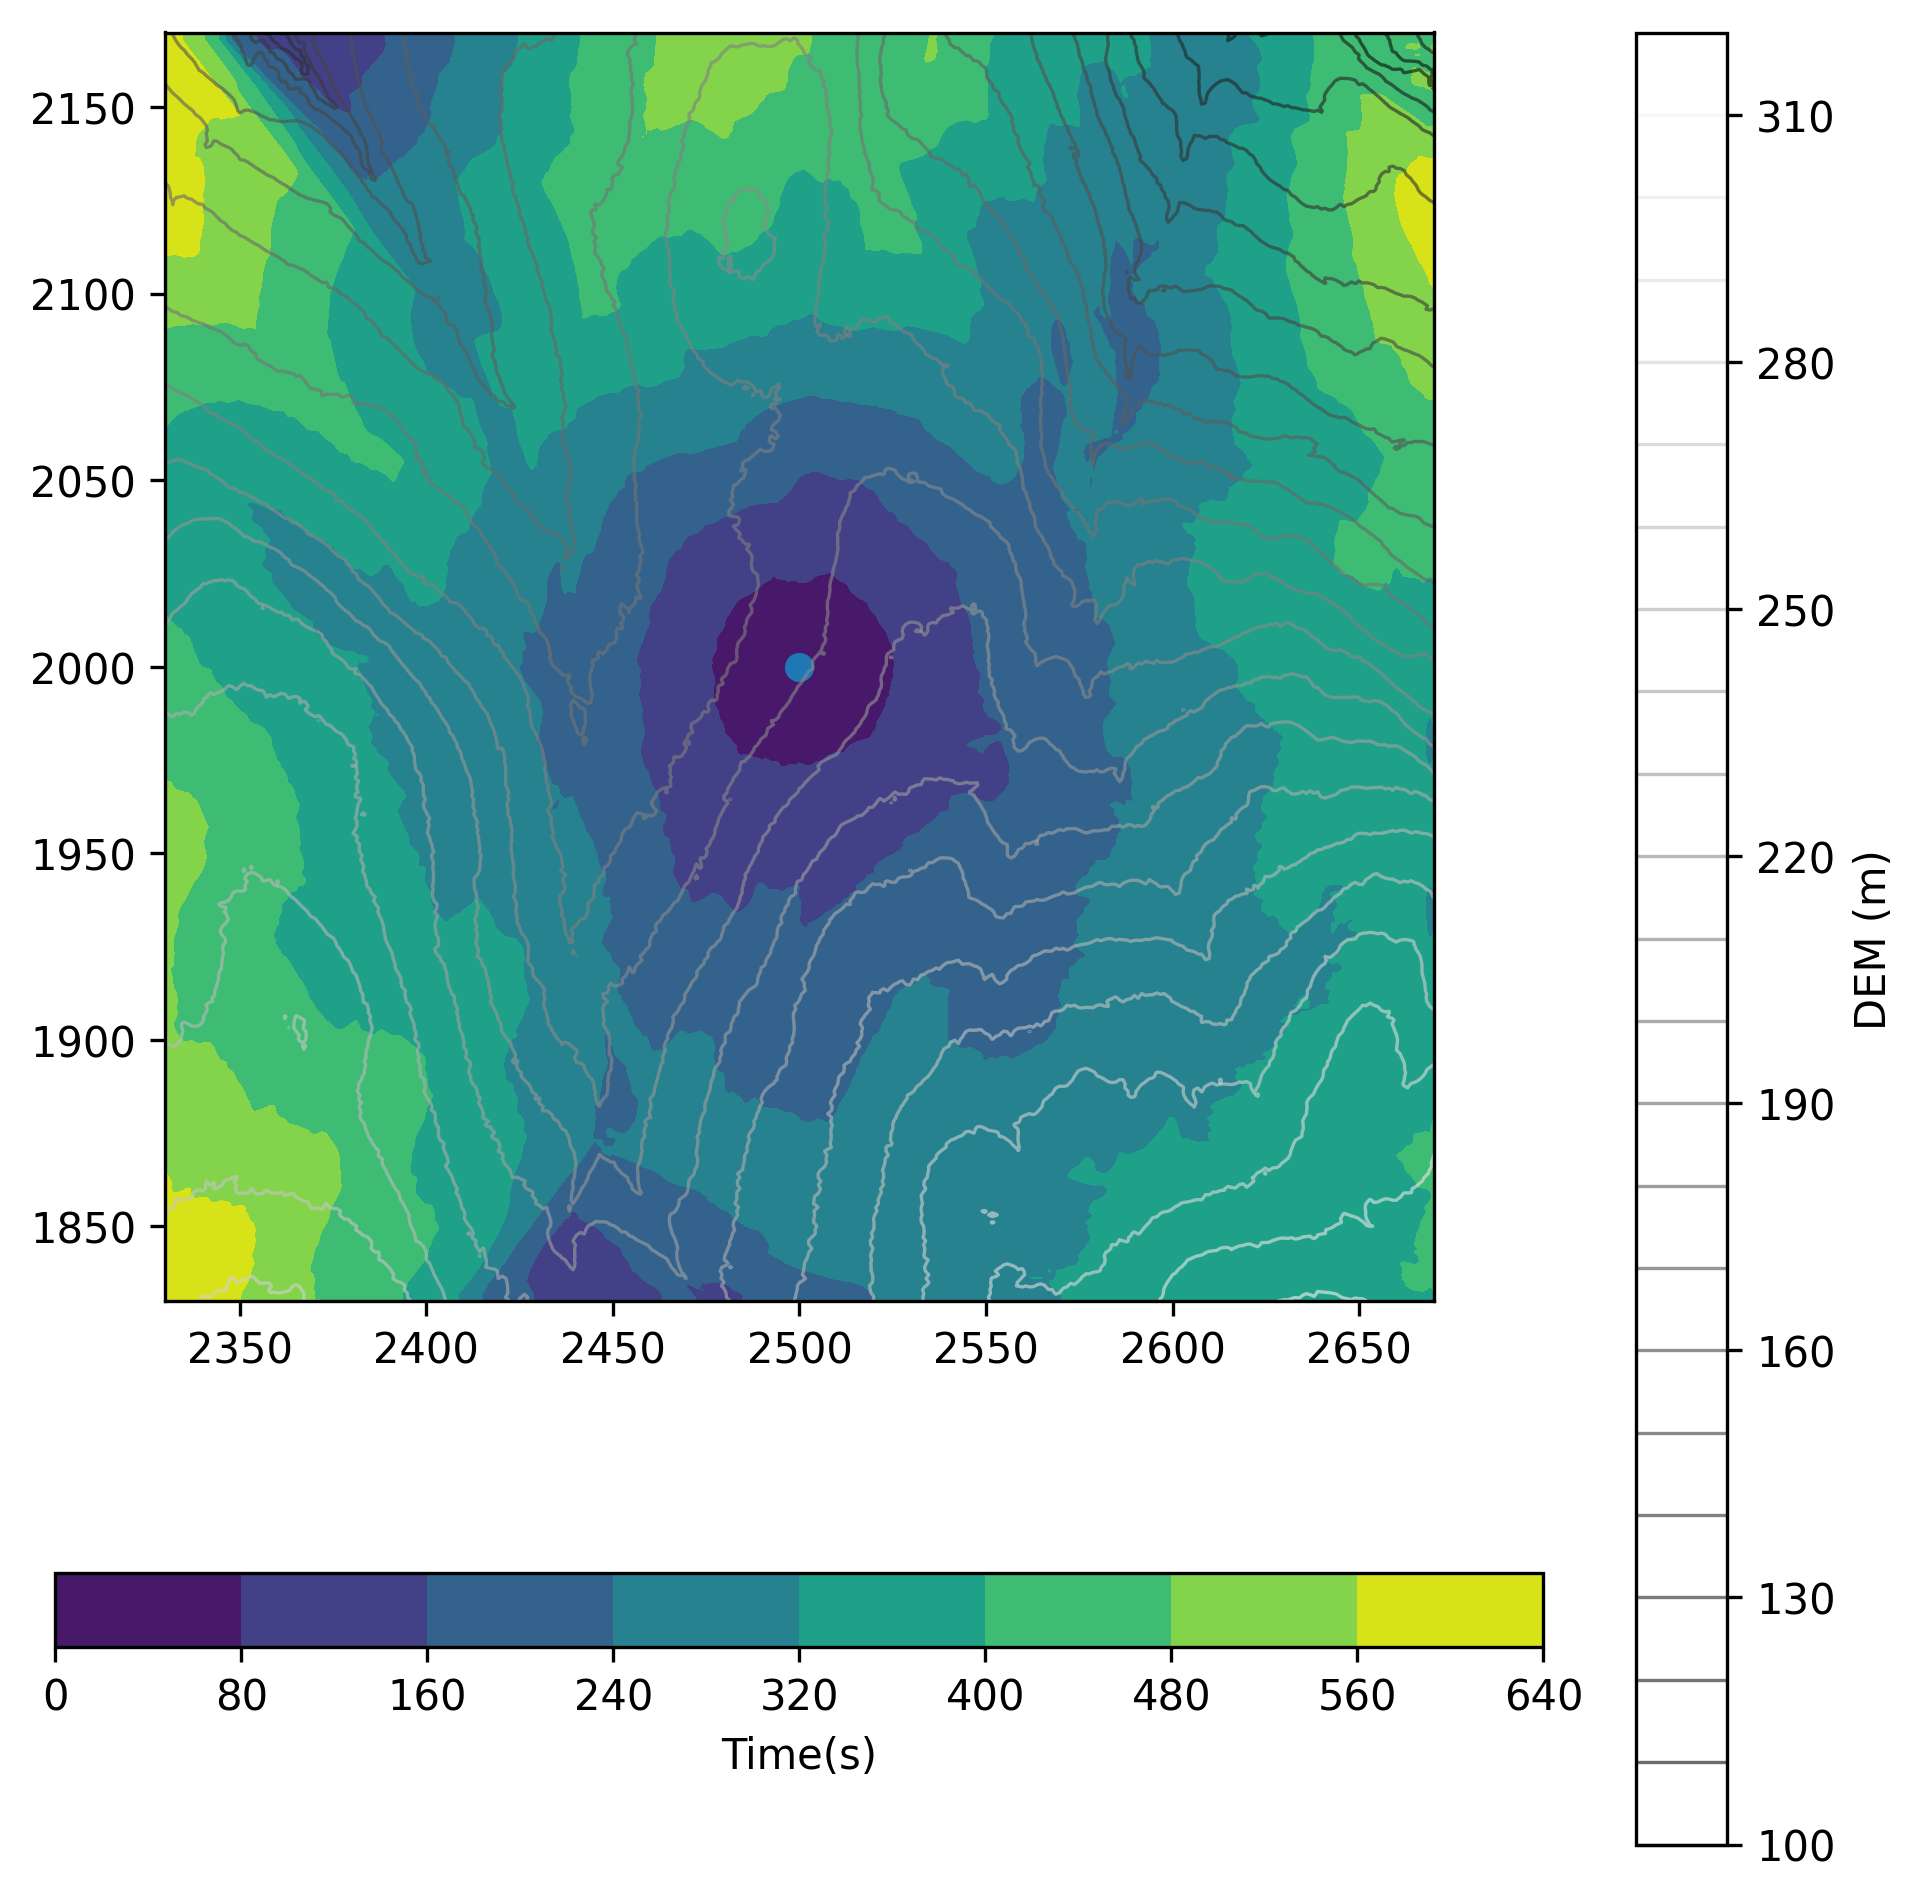

In [17]:
plot(sim.times, sim.env.dem, "Time(s)", "DEM (m)")

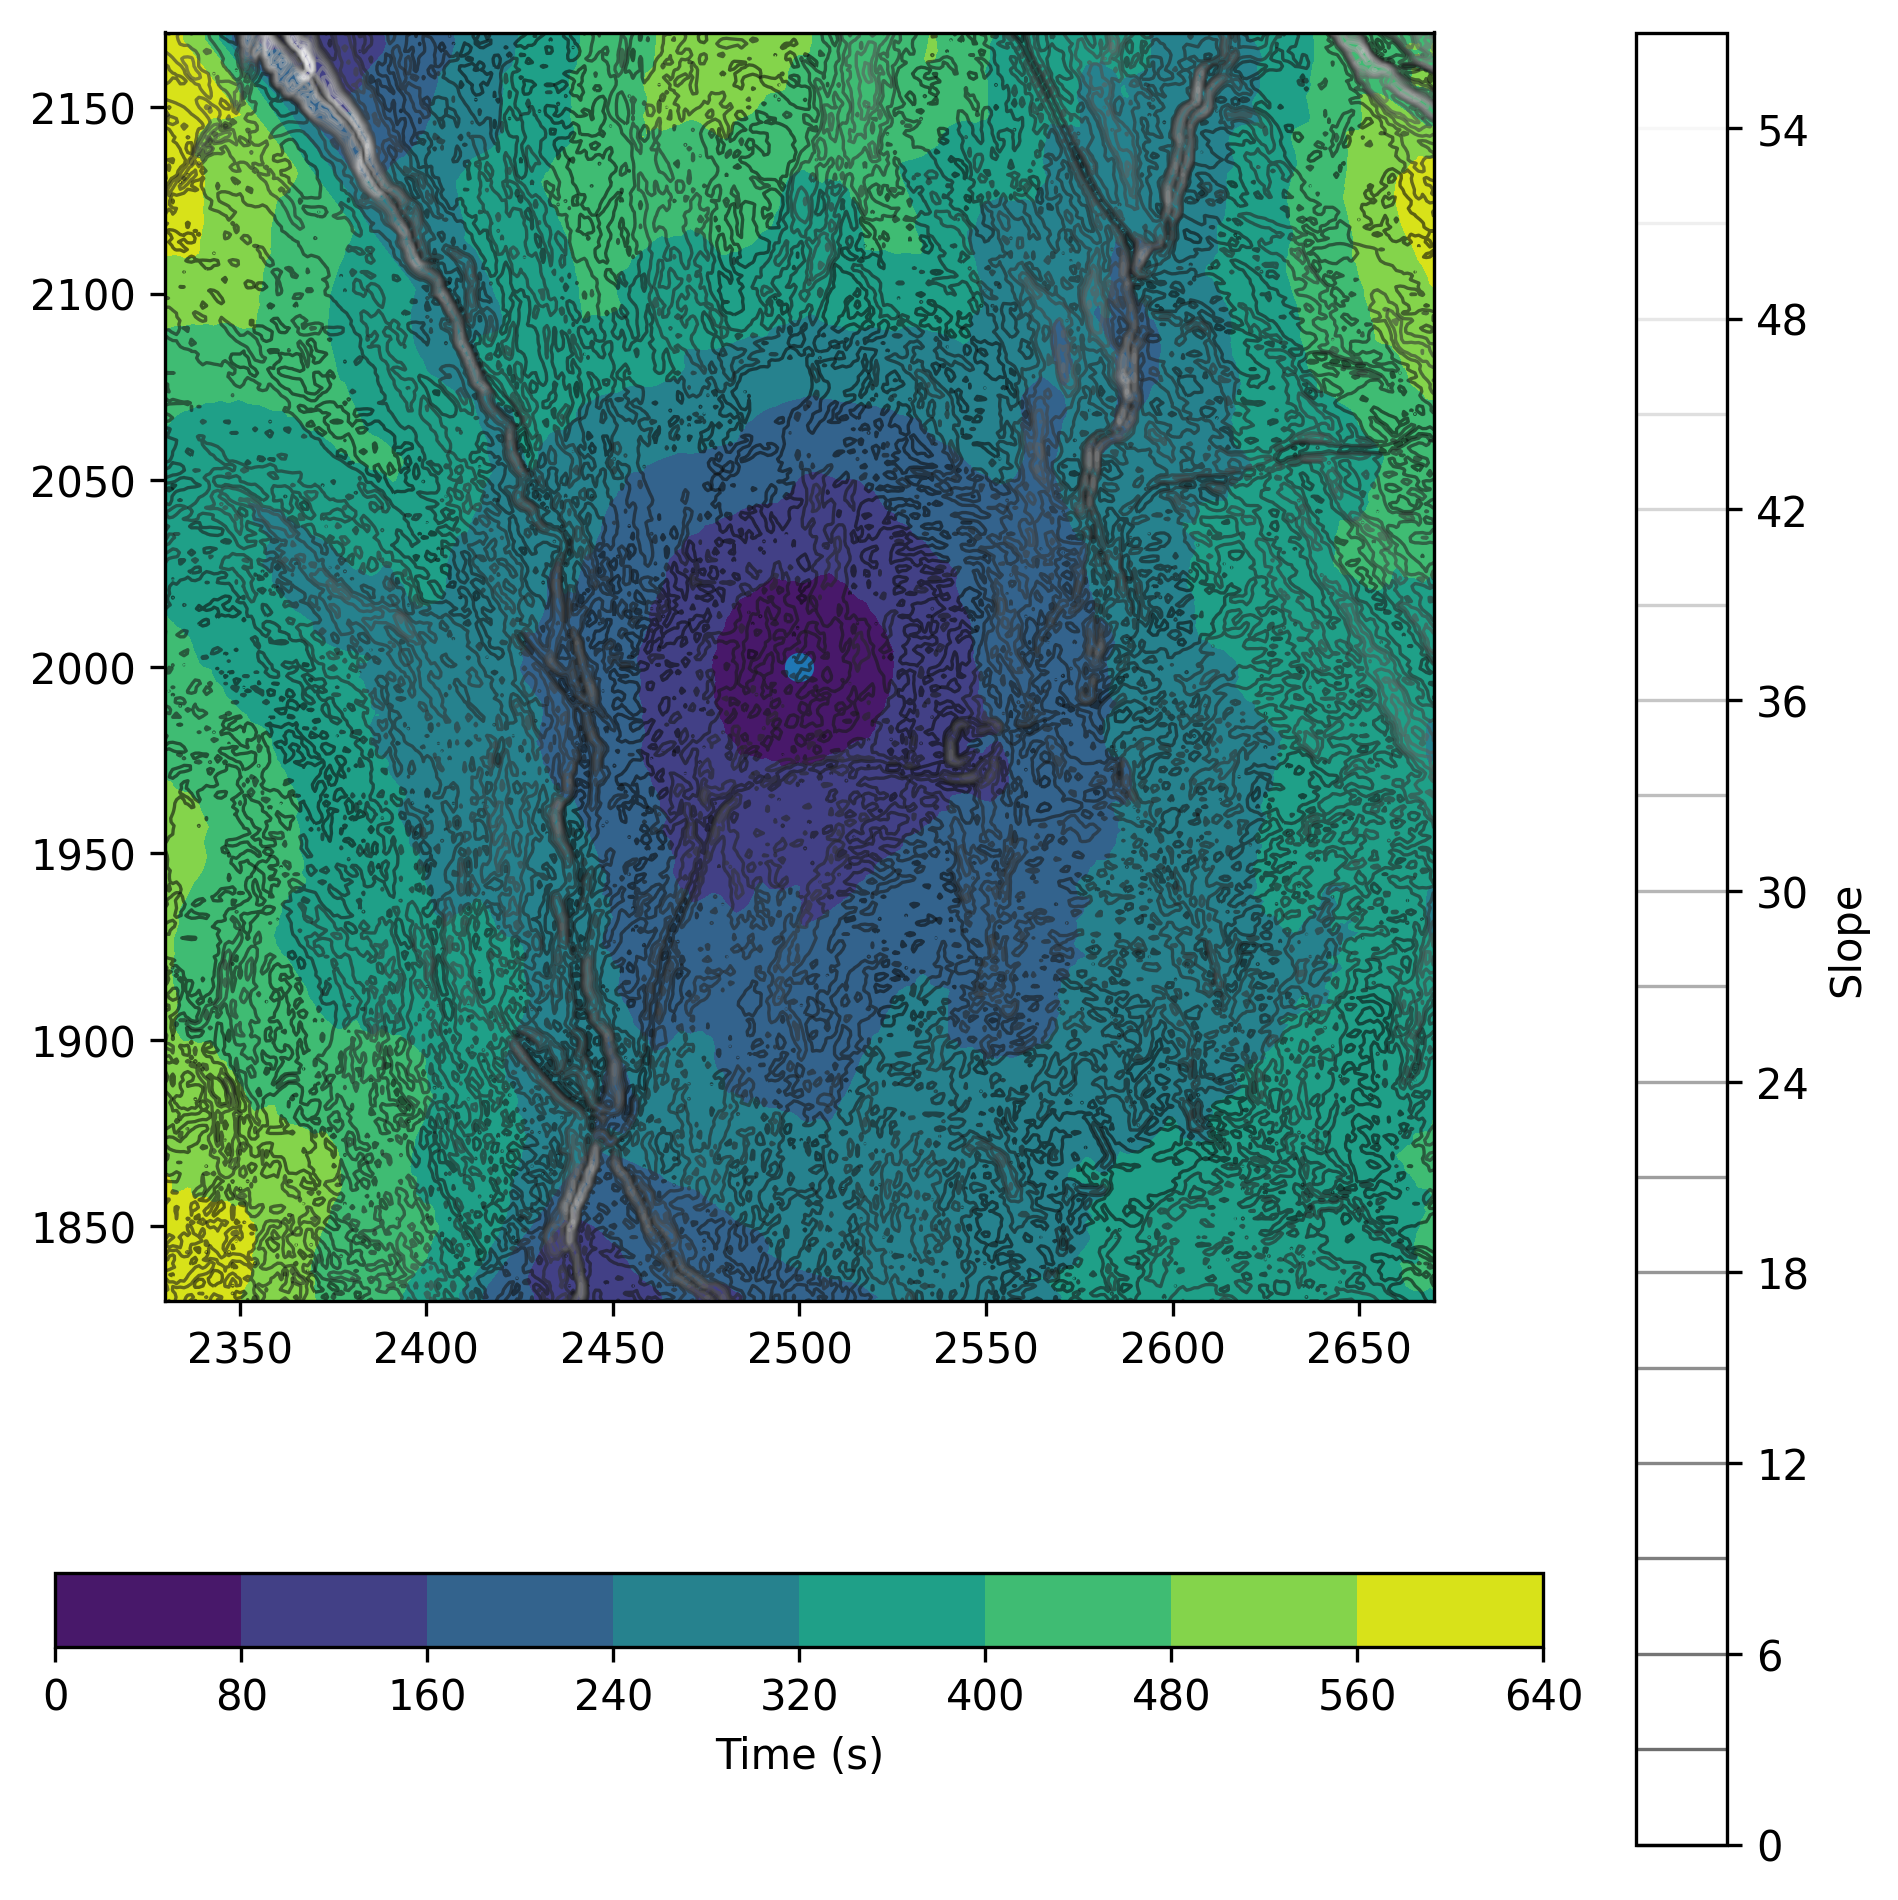

In [18]:
plot(sim.times, sim.env.slope, "Time (s)", "Slope")

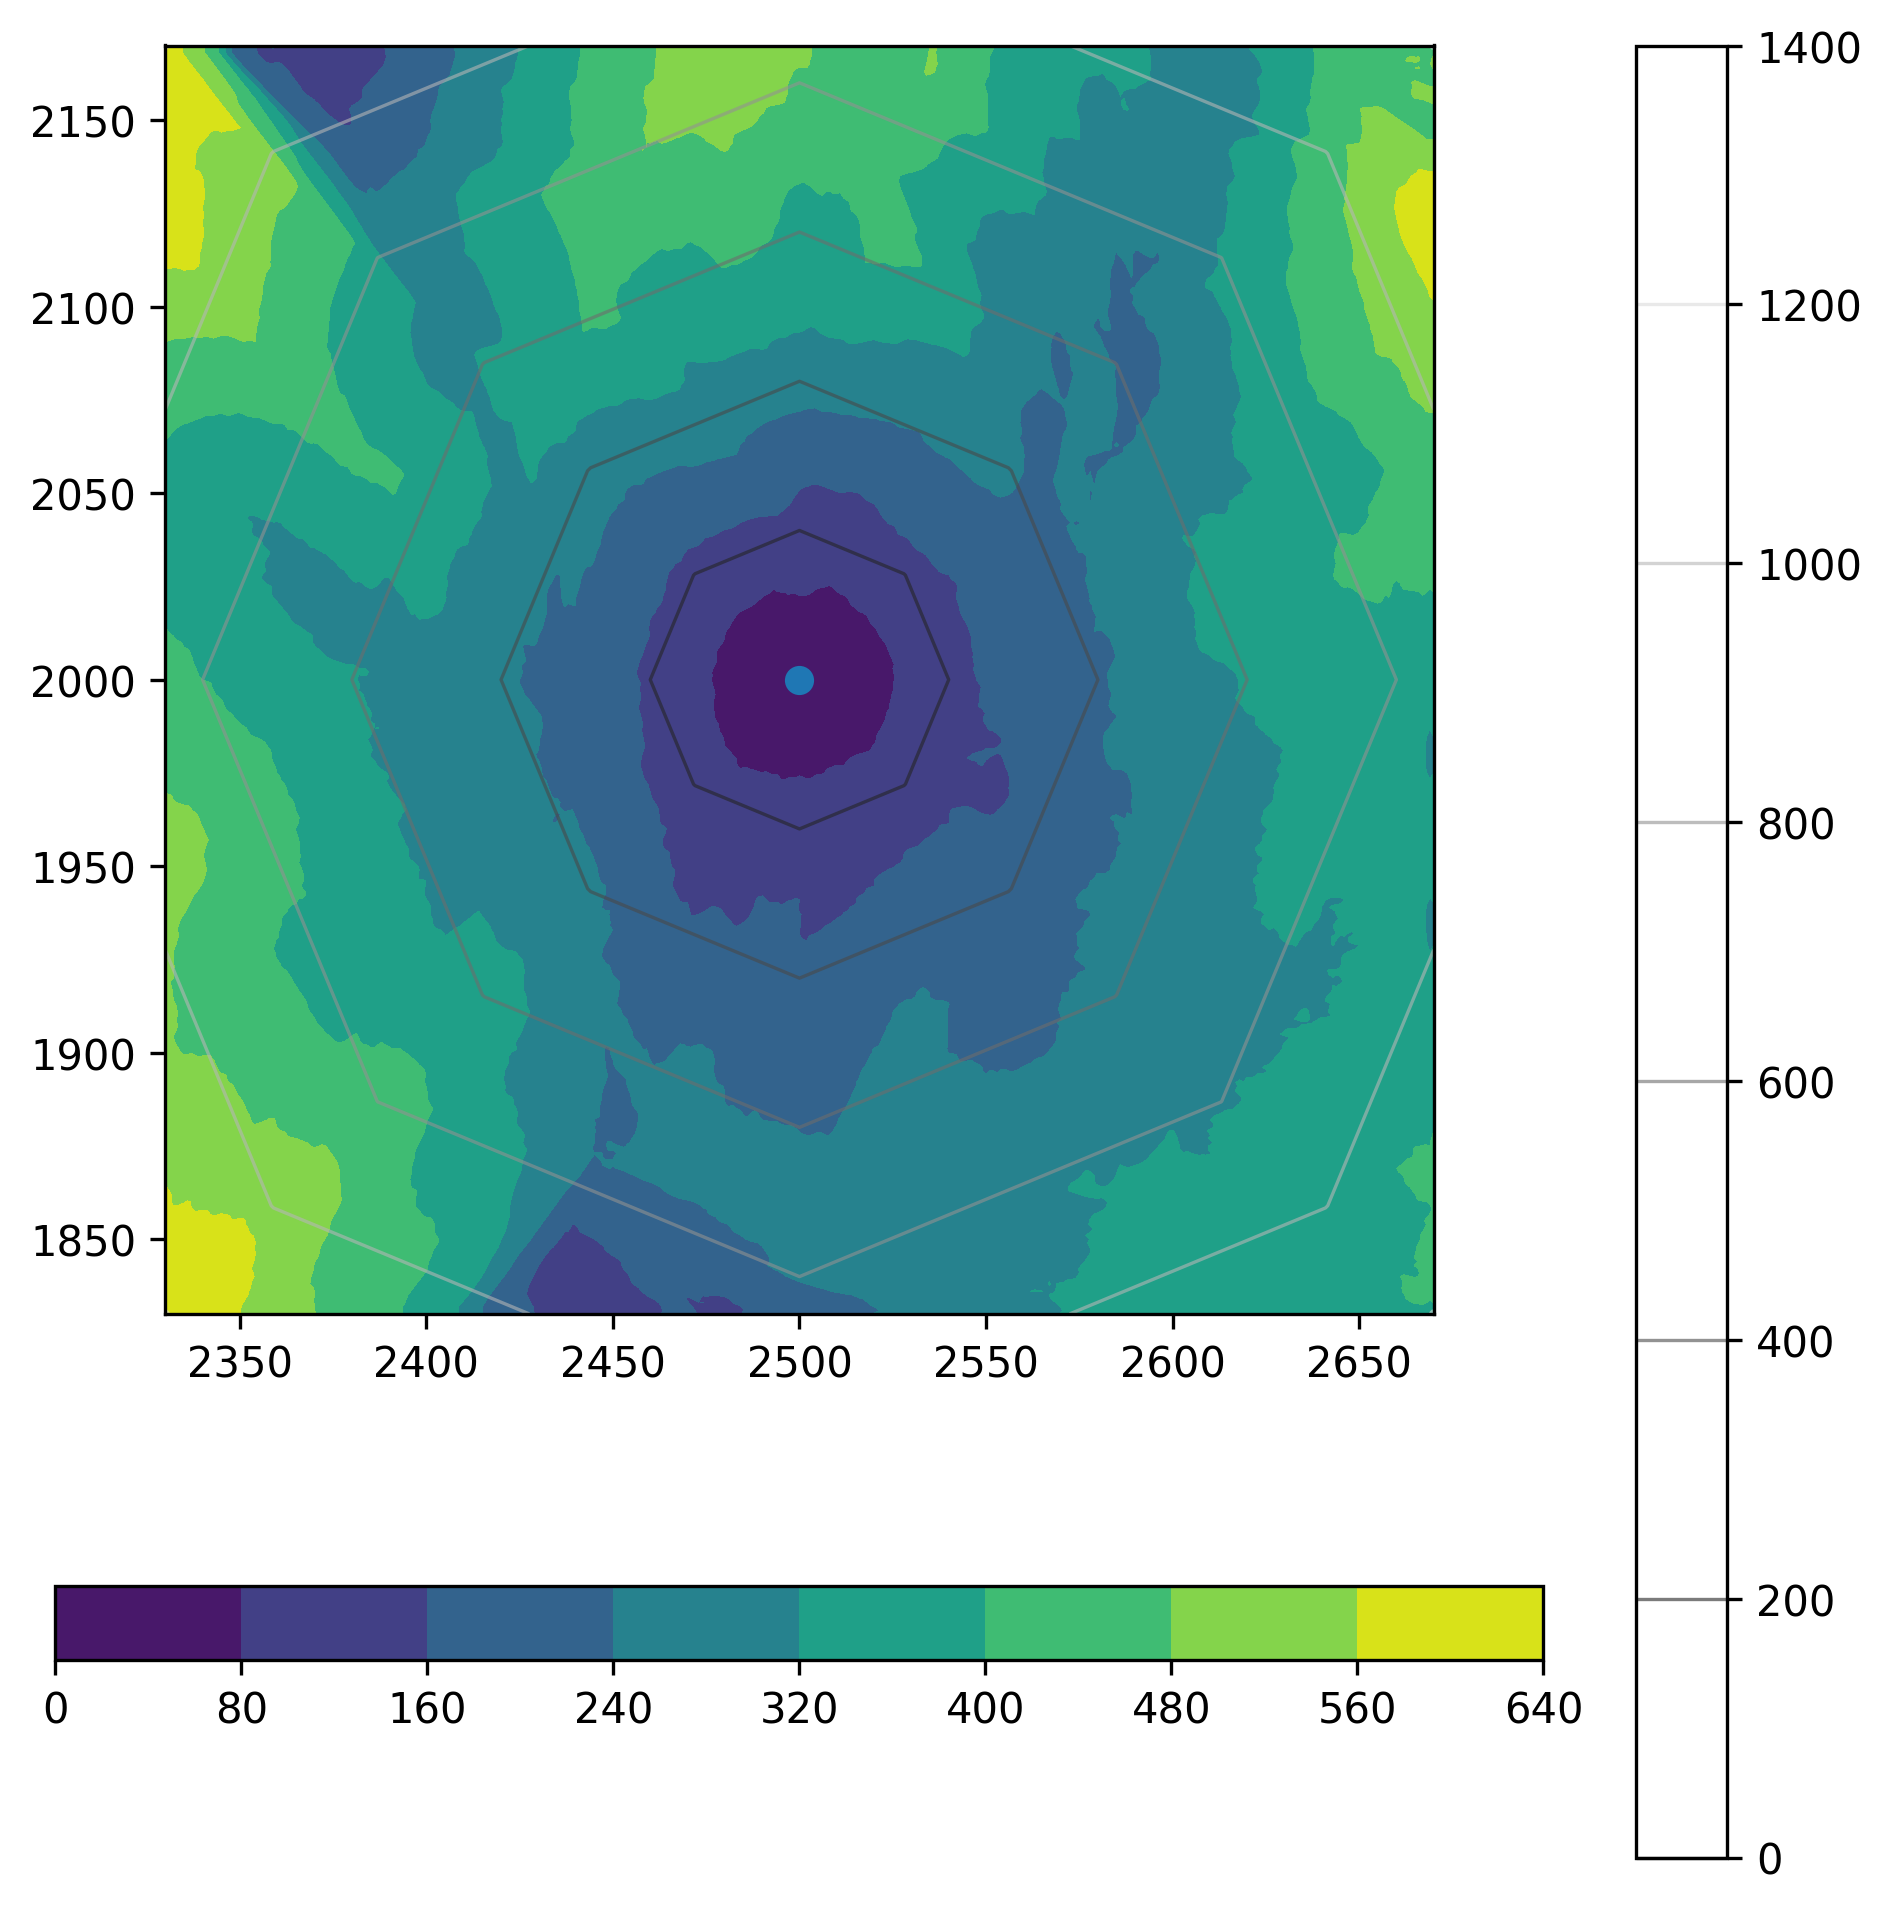

In [14]:
fig, ax = plt.subplots(figsize=(8,8), dpi=300)
b_plot = ax.contour(
    sim.distance,
    alpha=0.6,
    linewidths=0.8,
    cmap='gray')
a_plot = ax.contourf(sim.times)
ax.scatter(sim.start.x, sim.start.y)
fig.colorbar(b_plot)
fig.colorbar(a_plot, orientation='horizontal')
ax.set_aspect('equal')
ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])
plt.show()